In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from lit_modules.custom_wide_resnet_lit import WideResnetLit
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import MLFlowLogger

L.seed_everything(42)
torch.set_float32_matmul_precision("medium")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Seed set to 42


Using device: cuda


In [2]:
IMAGE_SIZE = 32
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
# source: https://pytorch.org/vision/stable/transforms.html
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)
transforms_test = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)
train_dataset = datasets.CIFAR100(
    root="./data", train=True, download=True, transform=transforms_train
)
test_dataset = datasets.CIFAR100(
    root="./data", train=False, download=True, transform=transforms_test
)
N = len(train_dataset)
num_val = int(0.2 * N)
indices = torch.randperm(N)[:num_val]
mask = torch.ones(N, dtype=torch.bool)
mask[indices] = False
train_indices = torch.nonzero(mask, as_tuple=False).squeeze(1)
validation_dataset = torch.utils.data.Subset(train_dataset, indices=indices)
train_dataset = torch.utils.data.Subset(train_dataset, indices=train_indices)
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset, batch_size=512, num_workers=30, persistent_workers=True
)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=512, num_workers=30, persistent_workers=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=512, num_workers=30, persistent_workers=True
)

100%|██████████| 169M/169M [00:17<00:00, 9.93MB/s] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1308641].


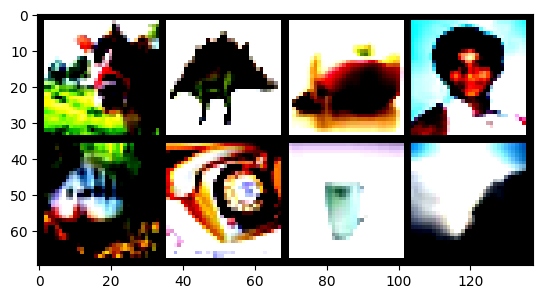

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def show_img(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


images, labels = next(iter(train_loader))
show_img(torchvision.utils.make_grid(images[:8], nrow=4, padding=2))

In [4]:
class DataModule(L.LightningDataModule):
    def __init__(self, train_loader, validation_loader, test_loader):
        super().__init__()
        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.test_loader = test_loader

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.validation_loader

    def test_dataloader(self):
        return self.test_loader


data = DataModule(train_loader, validation_loader, test_loader)
model = WideResnetLit(depth=32, weight_decay=10e-4, num_classes=100)
logger = MLFlowLogger(experiment_name="WideResnet-CIFAR100", save_dir="mlruns")
trainer = L.Trainer(
    max_epochs=50,
    logger=logger,
    callbacks=[
        ModelCheckpoint(
            monitor="val_acc",
            mode="max",
            dirpath="checkpoints/wide_resnet",
            filename="{epoch:02d}-{val_acc:.3f}",
        )
    ],
    precision="16-mixed",
    num_sanity_val_steps=0,
)
trainer.fit(model, datamodule=data)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Experiment with name WideResnet-CIFAR100 not found. Creating it.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | WideResNet         | 7.4 M  | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
4 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params
29.693    Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 79/79 [00:20<00:00,  3.93it/s, v_num=9ec0, train_loss_step=0.00599, train_acc_step=1.000, val_loss=1.700, val_acc=0.572, train_loss_epoch=0.0647, train_acc_epoch=0.996]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 79/79 [00:20<00:00,  3.91it/s, v_num=9ec0, train_loss_step=0.00599, train_acc_step=1.000, val_loss=1.700, val_acc=0.572, train_loss_epoch=0.0647, train_acc_epoch=0.996]


Validation accuracy at epoch 49 is 0.572

In [5]:
best_ckpt = trainer.checkpoint_callback.best_model_path
trainer.test(model, datamodule=data, ckpt_path=best_ckpt)
None

Restoring states from the checkpoint path at /home/dxzielinski/Desktop/github-repositories/optimization-data-analysis/model_training_notebooks/checkpoints/wide_resnet/epoch=49-val_acc=0.572.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/dxzielinski/Desktop/github-repositories/optimization-data-analysis/model_training_notebooks/checkpoints/wide_resnet/epoch=49-val_acc=0.572.ckpt


Testing DataLoader 0: 100%|██████████| 20/20 [00:01<00:00, 13.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5662999749183655
        test_loss           1.7078298330307007
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
